In [39]:
# установка дополнительных библиотек:
!pip install Afinn
!pip install nltk[twitter] 

# инструменты анализа и обработки данных
import pandas as pd
import numpy as np
import re
import geopy.distance
from scipy import stats
from category_encoders import  OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px

from wordcloud import WordCloud

# инструменты для лингвистического анализа:
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn
nltk.download('vader_lexicon')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

# Проведем разведывательный и первичный анализ данных

In [3]:
#посмотрим получившийся датасет
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [4]:
# объединяем датафреймы
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['reviewer_score'] = 0 
df = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [5]:
hotels = df.copy()
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

#### Датасет имеет 16 колонок. В двух колонках (координаты:lat, lng) присутствуют пропуски

In [6]:
#поиск пропусков в данных

null_data = hotels.isnull().sum()

print(f'\nСтолбцы с пропусками данных:\n{null_data[null_data > 0]}')


Столбцы с пропусками данных:
lat    3268
lng    3268
dtype: int64


### Для дальнейшей работы и удобства определения места положения отеля и создадим колонку со страной отеля

In [7]:
hotels['hotel_address'].unique()

array(['Via Senigallia 6 20161 Milan Italy',
       'Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands',
       'Mallorca 251 Eixample 08008 Barcelona Spain', ...,
       '22 avenue de Villiers 17th arr 75017 Paris France',
       '17 rue de Richelieu 1st arr 75001 Paris France',
       '64 Rue Crozatier 12th arr 75012 Paris France'], dtype=object)

#### В адрессах отелей указаны город и страна. Среди городов присутствуют только столицы.

In [8]:
# исследуем данные о названии на наличие пропусков и дубликатов:
pivot_n = hotels[['hotel_address', 'hotel_name']].groupby(
    by='hotel_name'
).nunique()

name_rep = pivot_n[pivot_n['hotel_address'] != 1].index.to_list()
mask = hotels['hotel_name'].isin(name_rep)
addresses_rep = hotels[mask][['hotel_name', 'hotel_address']].value_counts()

print('Дублирование названия отеля:')
display(addresses_rep)

# чтобы различать эти отели при анализе - добавим в название город:
hotels['hotel_name'] = hotels.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in name_rep)
    else row['hotel_name'], axis=1)

print('\nПроверим полученные изменения:')
mask = hotels['hotel_name'].str.contains(name_rep[0])
display(hotels[mask]['hotel_name'].value_counts())

Дублирование названия отеля:


hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64


Проверим полученные изменения:


Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: hotel_name, dtype: int64

### Для дальнейшего анализа добавим параметр - страна отеля

In [9]:
#выбираем страну из адреса отеля
hotels['hotel_country'] = hotels['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

### Закодируем признак - страна, в которой находится отель

In [10]:
#закодируем название стран
import category_encoders as ce
encoder = ce.OneHotEncoder()
hotels['make_hotel_name'] = hotels['hotel_country'].astype('category')
data_bin = encoder.fit_transform(hotels['hotel_country'])
data_bin.rename(columns={'hotel_country' : 'hotel_country_c'}, inplace=True)
hotels = pd.concat([hotels, data_bin], axis=1)

### Для анализа расположения отеля необходимы координаты

In [11]:
# вычисляем средние значения координат:
coor_district = pd.pivot_table(
    hotels, 
    index='hotel_country', 
    values=['lat', 'lng'], 
    dropna=True, 
    aggfunc='mean')

hotels['lat'] = hotels.apply(
    lambda row: coor_district['lat'][row['hotel_country']] \
    if np.isnan(row['lat']) else row['lat'], axis=1)
hotels['lng'] = hotels.apply(
    lambda row: coor_district['lng'][row['hotel_country']] \
    if np.isnan(row['lng']) else row['lng'], axis=1)

In [12]:
#проверка наличия пропусков в данных

null_data = hotels.isnull().sum()

print(f'\nСтолбцы с пропусками данных:\n{null_data[null_data > 0]}')


Столбцы с пропусками данных:
Series([], dtype: int64)


#### Пропуски координат отсутствуют.
### Можно рассчитать расстояние от отеля до центра города, возможно это влияет на оценку отеля.

In [13]:
import geopy.distance

# для формирования нового признака используются координаты центра каждого города 

centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')

#функция вычисления до центра города по координатам
def get_dist_to_center(country, lng, lat):
   
    center_lat = centers['center_lat'][country]
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km

hotels_coord = hotels[['hotel_name', 'hotel_country', 'lng', 'lat']].drop_duplicates()
hotels_coord['hotel_distance_to_center'] = hotels.apply(
    lambda row: get_dist_to_center(row['hotel_country'], row['lng'], row['lat']), axis=1)

hotels_coord.drop(['hotel_country', 'lng', 'lat'], axis=1, inplace=True)

hotels = hotels.merge(hotels_coord, how='left', on='hotel_name', sort=False)


In [14]:
#посмотрим новый признак
hotels[['hotel_country', 'hotel_distance_to_center', 'reviewer_score']].sort_values(by='hotel_country').iloc[:10]

,hotel_country,hotel_distance_to_center,reviewer_score
420254,Austria,0.519129,10.0
135881,Austria,8.430679,5.8
287422,Austria,1.258480,10.0
324552,Austria,1.847219,8.3
230496,Austria,0.464687,9.6
287424,Austria,3.702350,10.0
135884,Austria,2.337170,9.2
418944,Austria,1.088678,10.0
151736,Austria,1.331707,7.9
468579,Austria,1.033456,8.8


#### Можно удалить колонку с координатами (lat, lng) и колонку make_hotel_country, которая больше использоваться не будет

In [15]:
#удаление неиспользуемых колонок
hotels = hotels.drop(columns=['lat', 'lng', 'make_hotel_name'])
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,sample,reviewer_score,hotel_country,hotel_country_1,hotel_country_2,hotel_country_3,hotel_country_4,hotel_country_5,hotel_country_6,hotel_distance_to_center
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0.0,Italy,1,0,0,0,0,0,7.837768
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0.0,Netherlands,0,1,0,0,0,0,6.243807
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,0,0.0,Spain,0,0,1,0,0,0,0.563942


### Перейдем к оценке стран, в которых расположены отели

In [16]:
hotels['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

#### Среди отелей, большая часть - это английские отели.
#### Визуализируем данную особенность

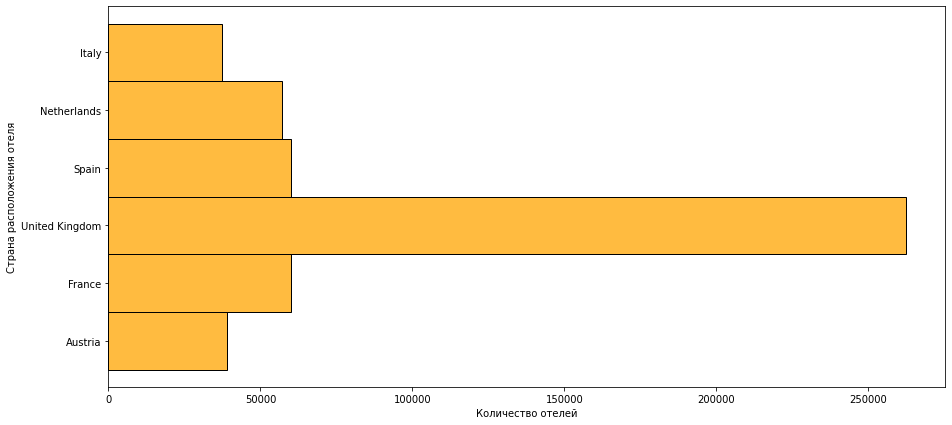

In [17]:
f, ax = plt.subplots(figsize = (15, 7))
ax = sns.histplot(data = hotels, y='hotel_country', color='orange')
ax.set_xlabel('Количество отелей')
ax.set_ylabel('Страна расположения отеля')
plt.show()

### Проведем анализ оценки в зависимости от страны отеля

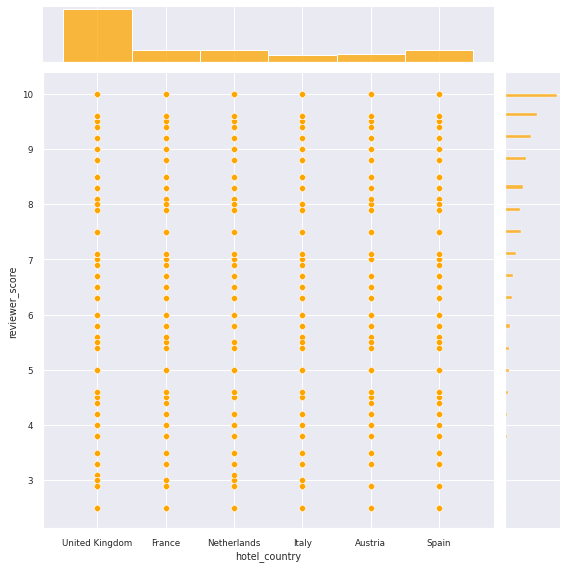

In [18]:
sns.set(font_scale=0.8)
sns.jointplot(x='hotel_country', y='reviewer_score', data=hotels[hotels['sample'] == 1], height=8, ratio=7, color='orange')

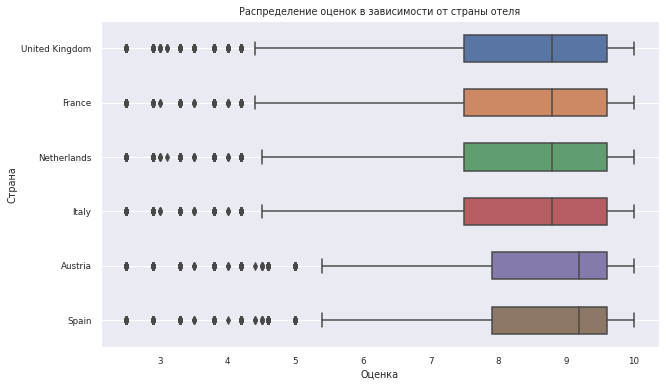

In [19]:
fig = plt.figure(figsize =(10, 6))
boxplot = sns.boxplot(
    data = hotels[hotels['sample'] == 1],
    y = 'hotel_country',
    x = 'reviewer_score',
    orient ='h',
    width = 0.5
)
boxplot.set_title('Распределение оценок в зависимости от страны отеля');
boxplot.set_xlabel('Оценка');
boxplot.set_ylabel('Страна');
boxplot.grid()

Согласно данным графикам наблюдается тенденция, что наибольшее количество оценок сосредоточено в области от 8 до 9,5. Стоит отметить, что медианы у отелей Австрии и Испании больше, чем у отелей других стран, возможно это связано с меньшим количеством оценок. Однако, это может в целом влиять на оценку отеля.

### Визуализируем зависимость оценки отеля от его расстояния от центра

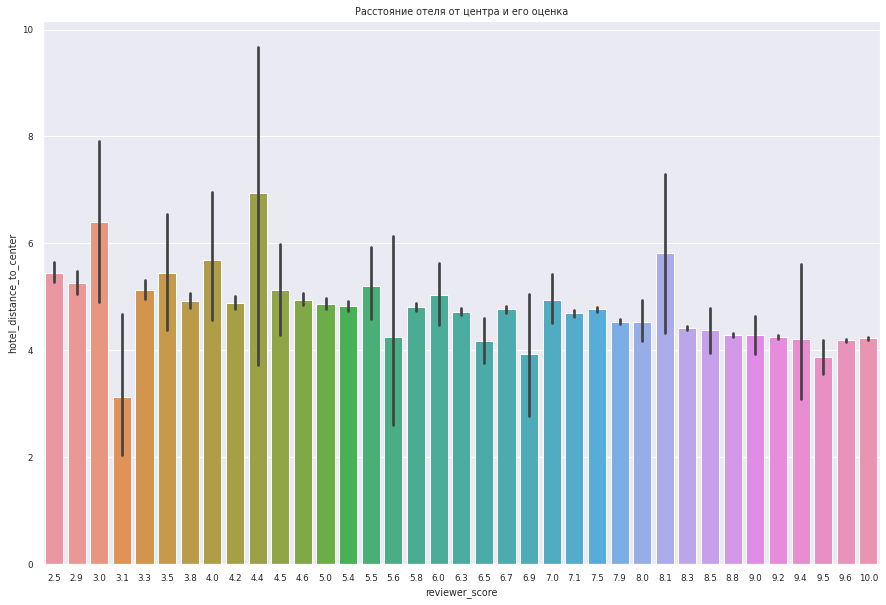

In [20]:
fig = plt.figure(figsize=(15, 10))
barplot = sns.barplot(
    data = hotels[hotels['sample'] == 1],
    x = 'reviewer_score',
    y = 'hotel_distance_to_center'
)
barplot.set_title('Расстояние отеля от центра и его оценка');

#### Заметно, что у отелей с большей оценкой расстояние до центра меньше

### Рассмотрим временной период опубликования оценок

In [22]:
#изменим формат даты, определим месяц опубликования
hotels['month'] = pd.to_datetime(hotels['review_date']).dt.month

In [23]:
# Готовим данные для графика в виде сводной таблицы
data = hotels[hotels['sample'] == 1]
data = hotels.groupby('month')['reviewer_score'].agg('mean').reset_index().sort_values(by='month')
data.head()

,month,reviewer_score
0,1,6.341309
1,2,6.391626
2,3,6.375261
3,4,6.334221
4,5,6.256184


In [24]:
#визуализируем полученную таблицу
px.scatter(data,x='month', y='reviewer_score', size_max=30, size='reviewer_score', color='reviewer_score')

#### Видна закономерность, что средний бал максимален во второй месяц и снижается к 10 месяцу.
То есть сезонность и оценка отеля имеют взаимосвязь.

### Рассмотрим связь тегов и оценки отеля

In [25]:
#создадим колонку с количеством тегов
def word_count(string):

    return(len(string.strip().split(" ")))

hotels['tags_c'] = hotels['tags'].apply(word_count)
hotels['tags_c'].describe()

count    515738.000000
mean         22.251279
std           3.990505
min           3.000000
25%          18.000000
50%          24.000000
75%          25.000000
max          44.000000
Name: tags_c, dtype: float64

#### Визуализируем распределением тегов в зависимости от оценок отелю

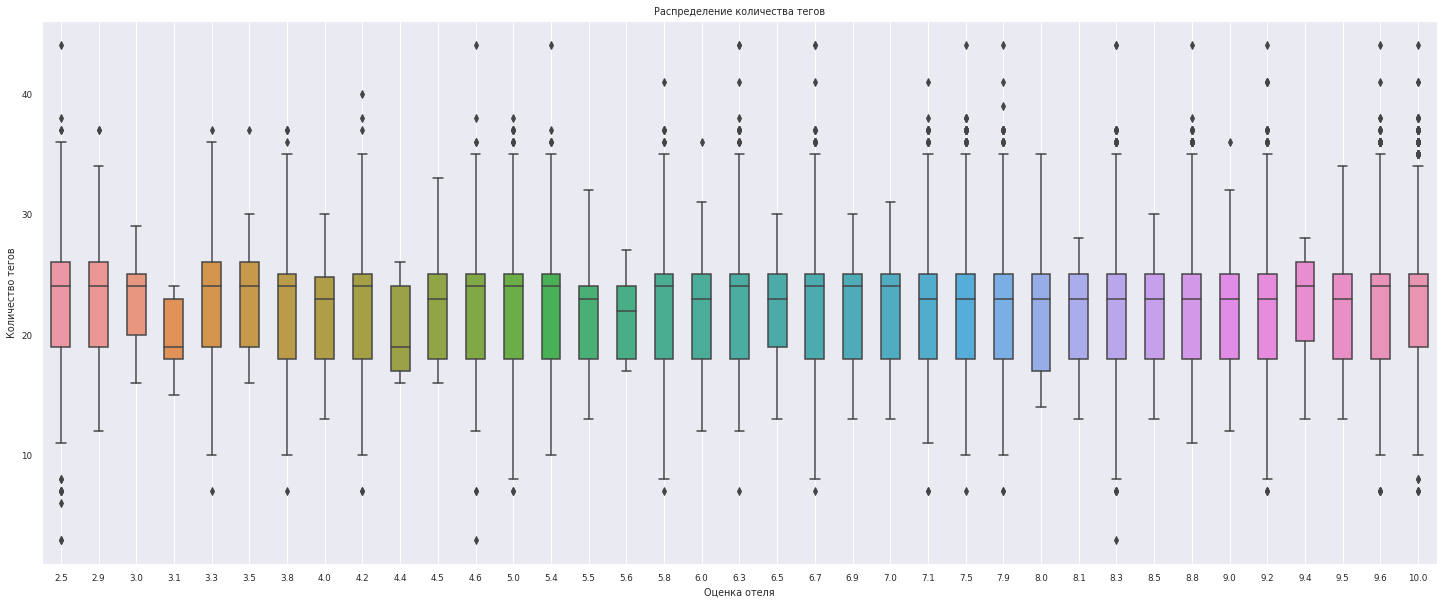

In [26]:
fig = plt.figure(figsize =(25, 10))
boxplot = sns.boxplot(
    data = hotels[hotels['sample'] == 1],
    y = 'tags_c',
    x = 'reviewer_score',
    orient ='v',
    width = 0.5
)
boxplot.set_title('Распределение количества тегов');
boxplot.set_xlabel('Оценка отеля');
boxplot.set_ylabel('Количество тегов');
boxplot.grid()

In [ ]:
data = hotels[hotels['sample'] == 1]
data = data.groupby('tags_c')['reviewer_score'].agg('mean').reset_index().sort_values(by='reviewer_score')
#визуализируем полученную таблицу
px.scatter(data,x='tags_c', y='reviewer_score', size_max=60, size='tags_c', color='tags_c')

#### Можно отметить, что  у отелей с оценкой от 8 до 10 количество тегов варьируется от 11 до 44, но в целом, чем выше оценка, тем больше количество тегов. Однако, можно заметить, что есть значения 22, 40 и 44. Однако их не получится исключить, так как такие же значения есть у отелей с высокой и низкой оценкой

Визуализируем самые популярные теги набора данных:


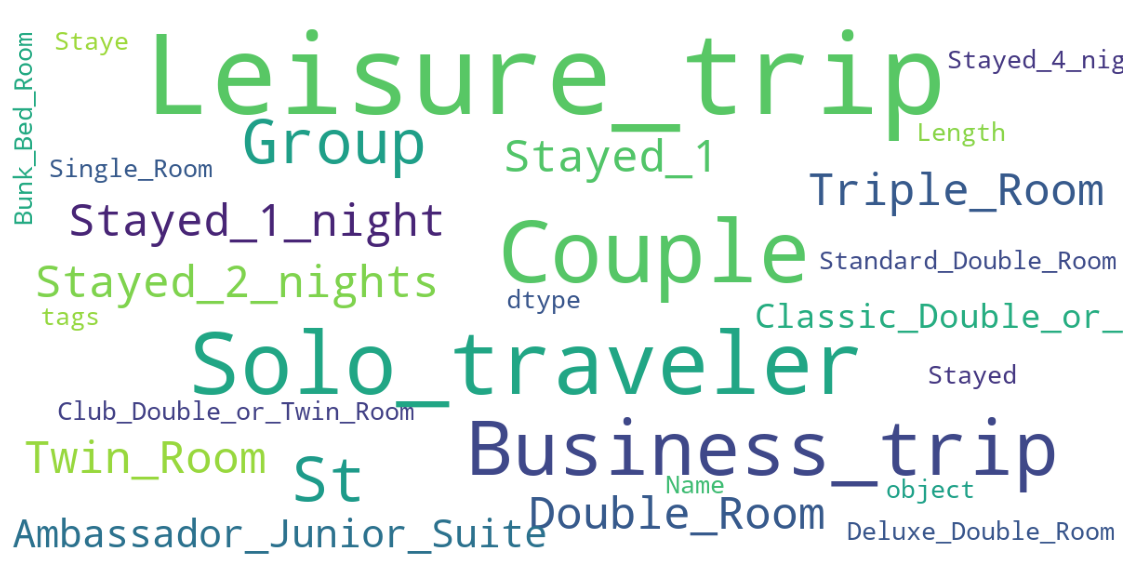

In [32]:
# сохраним в функцию способ визуализации слов, он еще пригодится:
def show_wordcloud(data, background_color, colormap):
    """Рисуем облако слов с заданными параметрами."""
    wordcloud = WordCloud(
        background_color = background_color,
        colormap = colormap,
        max_font_size = 40,
        max_words=100,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

    
print('Визуализируем самые популярные теги набора данных:')

# чтобы увидеть на визуализации именно слитные Тэги, а не отдельные слова, 
# преобразуем строки данных в блоки для каждого тега:
def get_tags_string(tags_data):
    """Соединяем все слова кажого тега нижним подчеркиванием."""
    tags_data = tags_data.replace('[', '').replace(']', '').replace("'", '')
    tags_list = tags_data.split(',')

    tags_string = ''
    for teg in tags_list:
        teg = teg.strip().replace(' ', '_')
        tags_string = tags_string + teg + ' '

    return tags_string

# рисуем диаграмму:
cloud = hotels['tags'].apply(get_tags_string)
show_wordcloud(cloud, 'white', 'viridis')

Рассмотрим и проанализируем типы тегов:

In [30]:
hotels['len_tags'] = hotels['tags'].apply(lambda x: len(x.split(',')))

print(f'Максимальное количество тегов в 1 строке данных: {hotels["len_tags"].max()}/n')

print('Примеры:')
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[0])
print(hotels[hotels['len_tags'] == hotels['len_tags'].max()]['tags'].iloc[1])

Максимальное количество тегов в 1 строке данных: 6/n
Примеры:
[' With a pet ', ' Leisure trip ', ' Family with young children ', ' Double or Twin Room 1 2 Adults ', ' Stayed 7 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Couple ', ' Deluxe Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']


**Можно выделить 6 типов тегов:**
* путешествие с домашними животными 
* путешествие по работе / отдых
* путешествие в каком составе (один, пара, компания друзей, семья с маленькими / взрослыми детьми, группа)
* категория номера
* длительность поездки
* доступ осуществляется с мобильного устройства

In [37]:
"""
Принцип выделения полезных свойств следующий -  максимальное 
количество тегов 6 и известны их возможные типы. Все они, кроме типа комнаты, 
укладываются в стандартный шаблон. Будем искать в каждой строке один из пяти
известных шаблонов тега и удалять из строки после обработки. Если останется 
какой-то еще тег - он и будет типом номера.
"""

# создаем новые признаки:
def get_tags(tags_string):
    """Выделение 6 типов тегов по шаблонам."""
    tags_string = tags_string.replace('[', '').replace(']', '')
    tags_string = tags_string.replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    # сразу кодируем тип путешественника:
    reviewer_types = {'Solo traveler': 1,
                      'Couple': 2,
                      'Travelers with friends': 3,
                      'Family with young children': 4,
                      'Family with older children': 5,
                      'Group': 6}

    # формируем новые параметры:
    tag_from_mobile = 0
    tag_with_pet = 0
    tag_leisure_trip = 1 #  по умолчанию не считаем поездку командировкой
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_room_type = ''
    
    # распределяем те теги, которые есть в исходной строке:
    for teg in list(tags_list):
        if teg == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(teg)

        if teg == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(teg)

        if teg == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(teg)

        if teg == 'Leisure trip':
            tags_list.remove(teg)

        if teg in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[teg]
            tags_list.remove(teg)

        if re.fullmatch(r'Stayed\s\d+\snight\w?', teg):
            tag_count_nights = [float(s) for s in re.findall(r'-?\d+\.?\d*', teg)][0]           
            tags_list.remove(teg)
            
        if len(tags_list) > 0:
            tag_room_type = tags_list[0]

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_room_type


# формируем новые признаки:
hotels[['tag_from_mobile',
        'tag_with_pet',
        'tag_leisure_trip',
        'tag_reviewer_type',
        'tag_count_nights',
        'tag_room_type']
] = pd.DataFrame(hotels['tags'].apply(get_tags).to_list(), index=hotels.index)

print('\nКоличество уникальных значений в новых признаках:')
hotels[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_room_type']].nunique()


Количество уникальных значений в новых признаках:


tag_from_mobile         2
tag_with_pet            2
tag_leisure_trip        2
tag_reviewer_type       6
tag_count_nights       32
tag_room_type        2394
dtype: int64

Рассмотрим внимательно категории номеров. Возможно получится выделить их в группы. Кажется, что отзывы о пребывании туристов, которые останавливаются в большом клубном номере с видом и в маленьком экономе могут сильно отличаться.

    Из типа номера дополнительно выделим признак - номер с видом (вероятно средний балл отзывов гостей таких номеров должен быть выше обычных).

In [40]:
# оптимизируем тип данных (для последующей диаграммы):
hotels['tag_count_nights'] = hotels['tag_count_nights'].astype('int8')

# добавим признак номера с видом:
hotels['tag_view_room'] = hotels['tag_room_type'].apply(
    lambda x: 1 if ('View' in x) | ('Panoramic' in x) else 0)


# сформируем список основных категорий отельных номеров 
# и присвоим соответствующее значение каждой группе:
def get_room_type(tag):
    """Классификация типа номера."""
    room_types = ['without Window', 'Guestroom', 'Classic', 'Single', 
                  'Standard', 'Superior', 'Comfort', 'Club', 'Suite', 
                  'Deluxe', 'King', 'Premier']

    for rt in room_types:
        if rt in tag:
            return rt

    if 'Double' in tag or 'Twin' in tag:
        return 'Double'

    return 'Other'


# группируем данные с типом номера:
hotels['room_type'] = hotels['tag_room_type'].apply(get_room_type)

# кодируем новые признаки
encoder_t = OneHotEncoder(cols=['tag_reviewer_type'], use_cat_names=True)
tag_type_bin = encoder_t.fit_transform(hotels['tag_reviewer_type'])
hotels = pd.concat([hotels, tag_type_bin], axis=1)

encoder_r = OneHotEncoder(cols=['room_type'], use_cat_names=True)
tag_rooms_bin = encoder_r.fit_transform(hotels['room_type'])
hotels = pd.concat([hotels, tag_rooms_bin], axis=1)

Визуализируем таблицу распределения целевой переменной в разрезе количества проведенных в отеле дней, а также соотношение ее средних значений в зависимости от категории номера

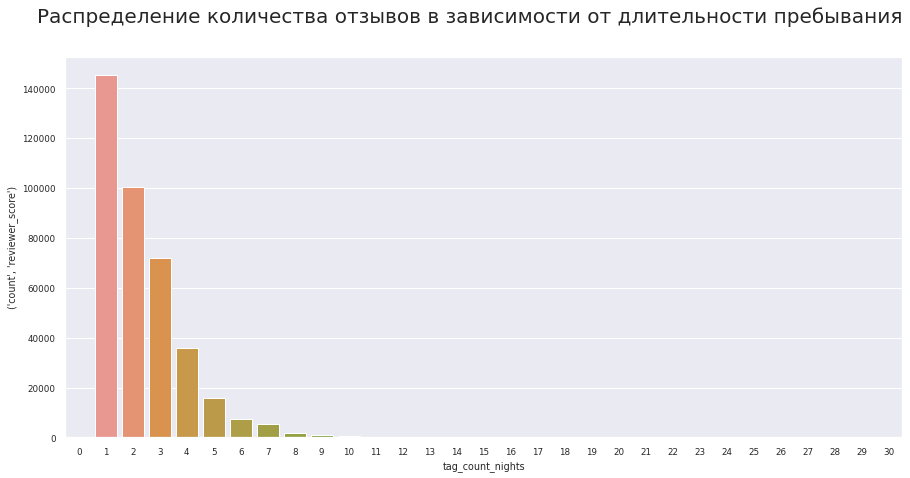

In [41]:
pivot_nights = pd.pivot_table(
    hotels[hotels['sample'] == 1], 
    index='tag_count_nights', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])
fig3, ax3 = plt.subplots(figsize=(15, 7))
plt.suptitle(
    'Распределение количества отзывов в зависимости от длительности пребывания', size=20)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('count', 'reviewer_score')]);

***Наибольшие группы - это туристы, совершавшие короткие поездки длительностью 1-3 ночи. Логично, для городских отелей. С возрастанием длительности пребывания - количество отзывов постепенно снижается, а после показателя в 14 ночей (стандартная длина отпуска) - их количество падает резко.***

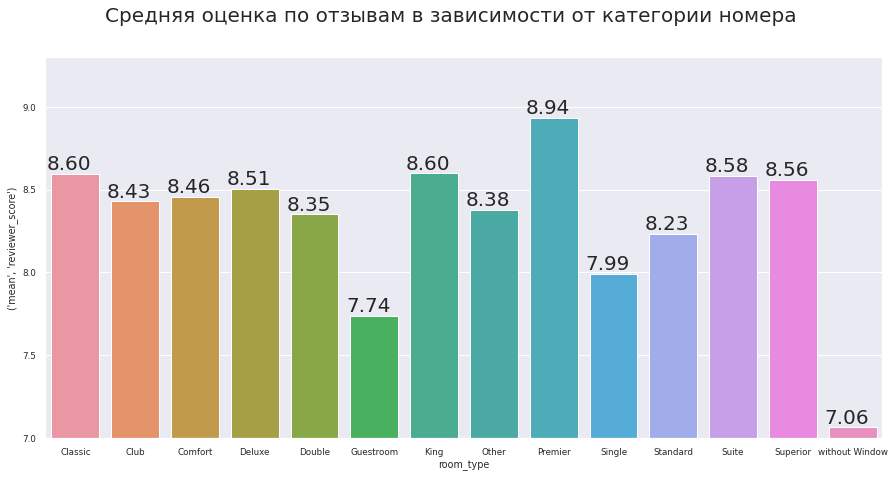

In [42]:
# визуализируем различия в оценках туристов, в зависимости от типа номера:
pivot_types = pd.pivot_table(hotels[hotels['sample'] == 1], 
                             index='room_type', 
                             values='reviewer_score', 
                             aggfunc=['count', 'mean'])

fig4, ax4 = plt.subplots(figsize=(15, 7))
plt.suptitle('Средняя оценка по отзывам в зависимости от категории номера', size=20)
bar_types = sns.barplot(
    x=pivot_types.index, 
    y=pivot_types[('mean', 'reviewer_score')])

for p in bar_types.patches:
    bar_types.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
    ha='center', va='bottom', fontsize=20)

plt.ylim(7, 9.3);

Номера без окон имеют наименьший средний бал.

In [44]:
# удалим вспомогательные столбцы:
hotels.drop(['tag_reviewer_type', 'room_type', 'tag_room_type', 'len_tags'], 
            axis=1, inplace=True)

### НЕПОСРЕДСТВЕННО ОТЗЫВ (‘negative_review’, ‘positive_review’)

Огромное количество информации для лучшего предсказания итоговой оценки содержится именно в этих столбцах!

In [47]:
# визуализируем основные слова положительных и отрицательных частей отзывов
# загружаем словарь для лемматизации
nlp = spacy.load('en_core_web_sm')
stop = stopwords.words('english')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()


def clean_text(text):
    """Очистка от стоп-слов и лемматизация текста"""
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if word not in stop]
    text = " ".join(text)
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


def get_words_string(words_data):
    """Соединение очищенных слов в единую строку"""
    words_string = ''
    for word in words_data:
        words_string = words_string + word + ' '
    return words_string


def draw_cloud(text_column, background, color_map):
    """Визуализация словарных наборов"""
    hotels['temp'] = hotels[text_column].apply(
        lambda x: x.replace('No Negative', '').replace('No Positive', ''))
    hotels.temp = hotels[text_column].apply(clean_text)
    cloud_data = hotels.temp.apply(get_words_string)
    # воспользуемся функцией для визуализации тегов:
    show_wordcloud(cloud_data, background, color_map)


ОБЛАКО СЛОВ ПОЗИТИВНЫХ ОТЗЫВОВ:



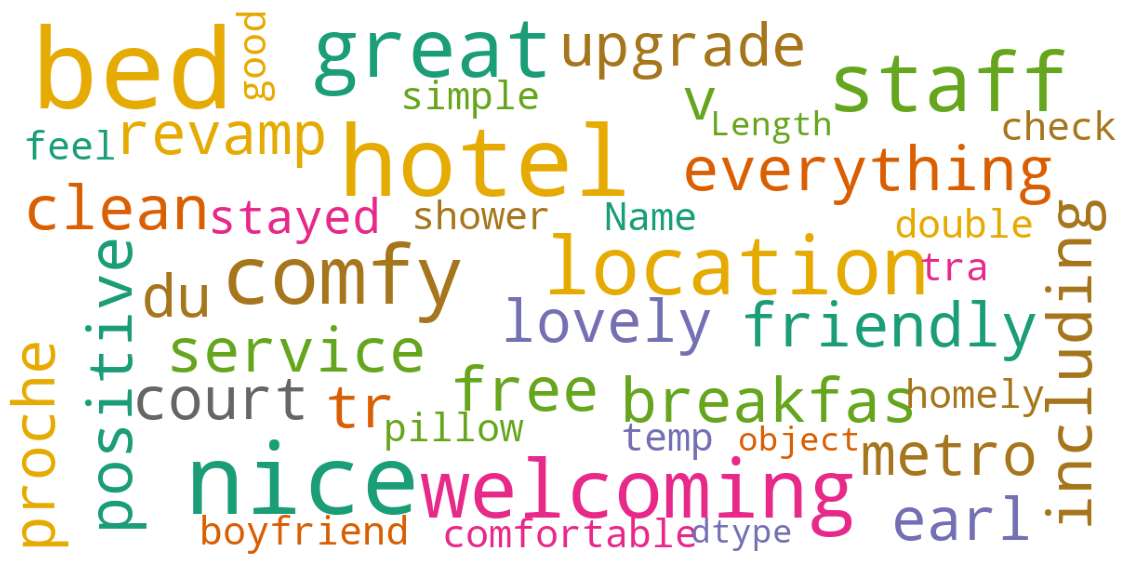

In [48]:
print('\nОБЛАКО СЛОВ ПОЗИТИВНЫХ ОТЗЫВОВ:\n')
draw_cloud('positive_review', 'white', 'Dark2');


ОБЛАКО СЛОВ НЕГАТИВНЫХ ОТЗЫВОВ:



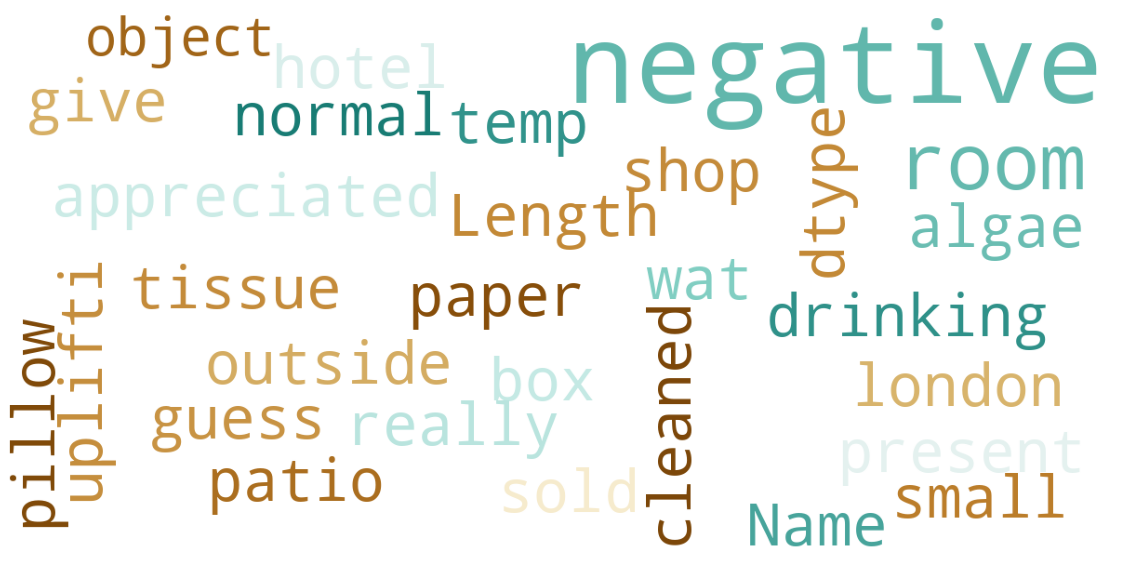

In [49]:
print('\nОБЛАКО СЛОВ НЕГАТИВНЫХ ОТЗЫВОВ:\n')
draw_cloud('negative_review', 'white', 'BrBG');

#### Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER:

In [50]:
# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований:')
print(sia_neg.polarity_scores(example), '\n')

# добавим контекст:
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

print(f' - после преобразований (для негативного контекста):')
print(sia_neg.polarity_scores(example))
print(f' - после преобразований (для позитивного контекста):')
print(sia_pos.polarity_scores(example))

# фразы "No Negative" тонально будет нести негативную окраску:
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}":')
print(sia_neg.polarity_scores(example))
example = 'Positive'
print(f'Словарь оценок фразы "{example}":')
print(sia_neg.polarity_scores(example))

# меняем метки отсутствия частей отзыва:
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [51]:
%%time

hotels['negative_review_sentiments'] = hotels['negative_review_temp'].apply(
    lambda x: sia_neg.polarity_scores(x))
hotels['positive_review_sentiments'] = hotels['positive_review_temp'].apply(
    lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
hotels['n_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['compound'])

CPU times: user 3min 55s, sys: 1.8 s, total: 3min 56s
Wall time: 3min 57s


### Создадим новый признак, объединяющий средний балл отеля и расстояние от центра. Затем оценим насколько такое соотношение влияет на оценку отеля

In [52]:
hotels['score_d'] = hotels['average_score'] / hotels['hotel_distance_to_center']
hotels[['score_d','reviewer_score']].sort_values(by='score_d').iloc[:15]

,score_d,reviewer_score
186702,0.297715,7.9
243006,0.297715,8.3
138516,0.297715,6.7
440122,0.297715,5.0
360476,0.297715,4.6
381575,0.297715,7.5
343627,0.297715,7.5
468695,0.297715,5.4
512735,0.297715,5.0
19868,0.297715,0.0


In [53]:
hotels['score_d'].describe()

count    515738.000000
mean          5.232711
std          11.084486
min           0.297715
25%           1.341332
50%           2.638481
75%           5.190872
max         314.464153
Name: score_d, dtype: float64

In [54]:
data = hotels[hotels['sample'] == 1]
data = data.groupby('score_d')['reviewer_score'].agg('mean').reset_index().sort_values(by='reviewer_score')
#визуализируем полученную таблицу
px.scatter(data,x='score_d', y='reviewer_score', size_max=60, size='score_d', color='score_d')

Значение 314 в данном случае можно определить как выброс, который необходимо заменить.

In [55]:
#заменяем значения - вылеты на среднее. В данном случае выбросы - это значения больше 300
hotels.loc[(hotels['score_d'] > 300), 'score_d'] = hotels['score_d'].median()

#### Чем меньше соотношение, тем оценка больше стремиться к низкому значению. Видимо при выборе отеля и дальнейшей оценки делается акцент на близость к центру отеля с учетом среднего балла.

### Создадим параметр общей средней оценки, учитывающий средний балл и все отзывы, поставленные ранее и оценки без отзывов

In [59]:
hotels['mean_number'] = (hotels['average_score'] / hotels['additional_number_of_scoring']
                        ) * hotels['total_number_of_reviews_reviewer_has_given']

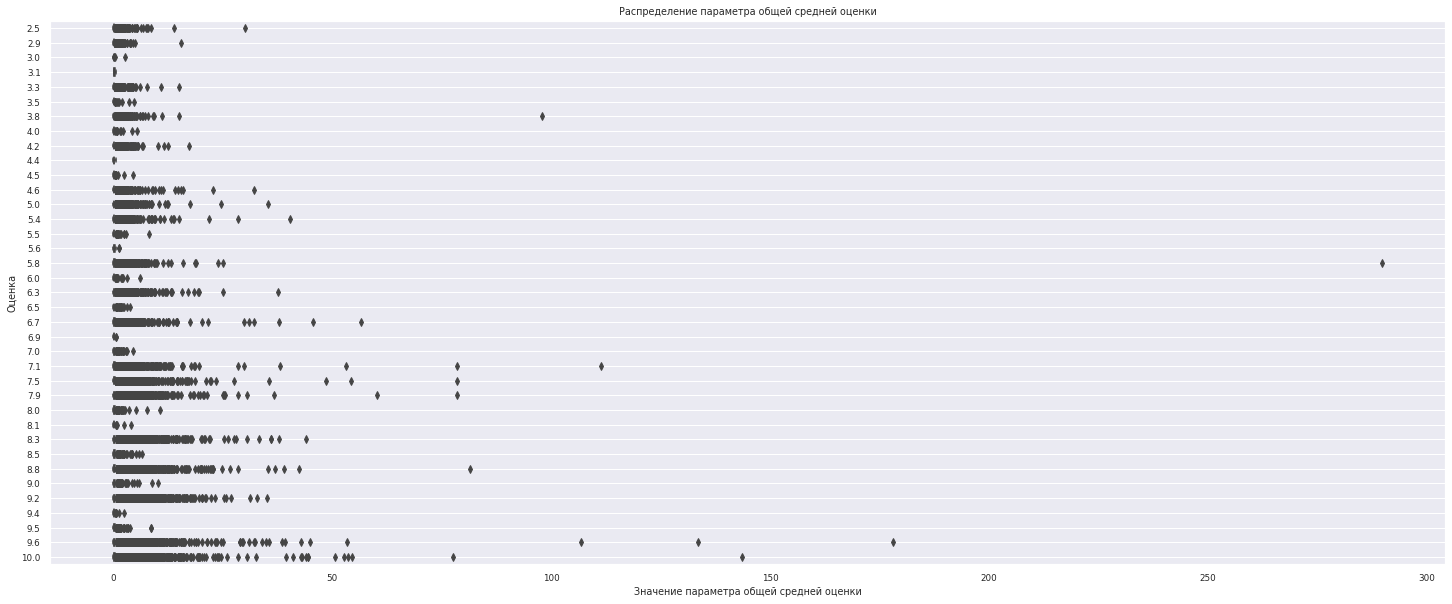

In [60]:
#визуализируем распределеине количества слов в положительных отзывах
fig = plt.figure(figsize =(25, 10))
boxplot = sns.boxplot(
    data = hotels[hotels['sample'] == 1],
    y = 'reviewer_score',
    x = 'mean_number',
    orient ='h',
    width = 0.5
)
boxplot.set_title('Распределение параметра общей средней оценки');
boxplot.set_xlabel('Значение параметра общей средней оценки');
boxplot.set_ylabel('Оценка');
boxplot.grid()

In [62]:
#заменяем значения - вылеты на среднее. В данном случае выбросы - это значения больше 250
hotels.loc[(hotels['mean_number'] > 250), 'mean_number'] = hotels['mean_number'].mean()

### Рассмотрим влияние национальности на оценку отеля

In [63]:
hotels['reviewer_nationality'].describe()

count               515738
unique                 227
top        United Kingdom 
freq                245246
Name: reviewer_nationality, dtype: object

In [64]:
#сгруппириуем данные для оценки параметра национальность
data = hotels[hotels['sample'] == 1]
data = data.groupby('reviewer_nationality')['reviewer_score'].agg('mean').reset_index().sort_values(by='reviewer_score').iloc[:20]
data.head()

,reviewer_nationality,reviewer_score
5,American Samoa,4.60
47,Cook Islands,5.00
137,Montserrat,5.40
149,Northern Mariana Islands,5.80
127,Mali,6.44


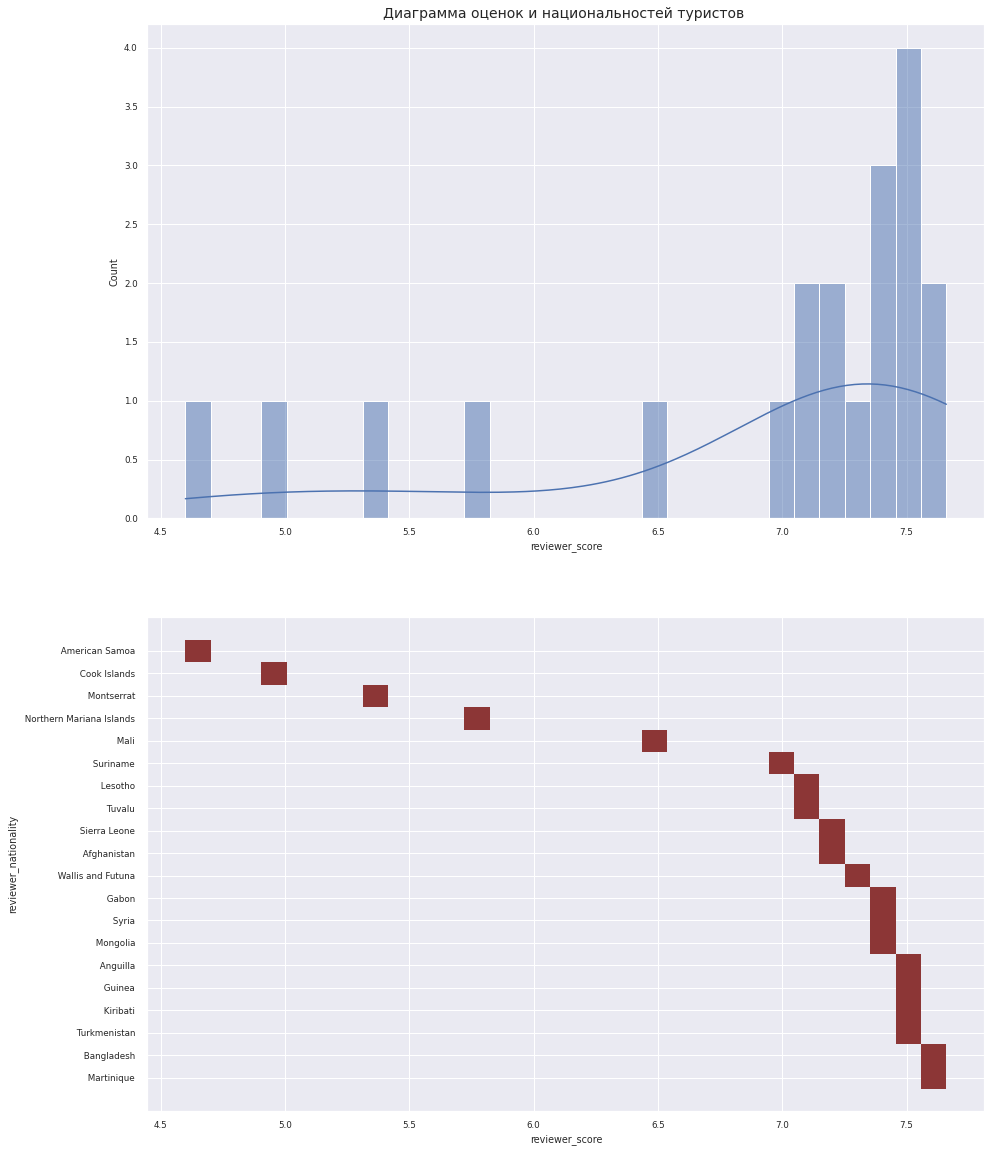

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
sns.histplot(
    data = data,
    x = 'reviewer_score',
    bins = 30,
    kde = True,
    ax = axes[0]
);
axes[0].set_title('Диаграмма оценок и национальностей туристов ', fontsize = 14)
sns.histplot(
    data = data,
    x = 'reviewer_score',
    y = 'reviewer_nationality',
    bins = 30,
    color = 'red',
    ax = axes[1]
);


#### Можно в целом заключить, что национальность посетителя связана с оценкой, видна очевидная зависимость. Посетители определенных стран давали определенную среднюю оценку.
#### Для дальнейшей работы с данным столбиком закодируем названия стран.

In [66]:
#закодируем название национальностей
import category_encoders as ce
ord_encoder = ce.OrdinalEncoder()
hotels['make_nationality'] = hotels['reviewer_nationality'].astype('category')
data_bin = ord_encoder.fit_transform(hotels['reviewer_nationality'])
data_bin.rename(columns={'reviewer_nationality' : 'nationality'}, inplace=True)
hotels = pd.concat([hotels, data_bin], axis=1)

In [67]:
hotels[['reviewer_nationality', 'nationality']].value_counts()

reviewer_nationality        nationality
 United Kingdom             1              245246
 United States of America   4               35437
 Australia                  12              21686
 Ireland                    7               14827
 United Arab Emirates       20              10235
                                            ...  
 Anguilla                   206                 1
 Cape Verde                 197                 1
 Northern Mariana Islands   225                 1
 Svalbard Jan Mayen         224                 1
 Palau                      227                 1
Length: 227, dtype: int64

### Для дальнейшей работы удалим столбцы со строковыми данными

In [78]:
df_train_w = hotels.copy()

In [79]:
# удаление столбцов со строковыми данными

df_train_w = df_train_w.drop(columns=[
    'hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'make_nationality',
    'negative_review', 'positive_review', 'tags', 'days_since_review', 'hotel_country',
    'temp', 'negative_review_temp', 'positive_review_temp', 'negative_review_sentiments', 
    'positive_review_sentiments', 'review_total_negative_word_counts'], axis=1)

In [80]:
df_train_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 53 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   hotel_country_1                             515738 non-null  int64  
 8   hotel_country_2                             515738 non-null  int64  
 9   hotel_country_3                             515738 non-null  int64  
 

### Проанализируем мультиколлинеарность полученных данных

<AxesSubplot:>

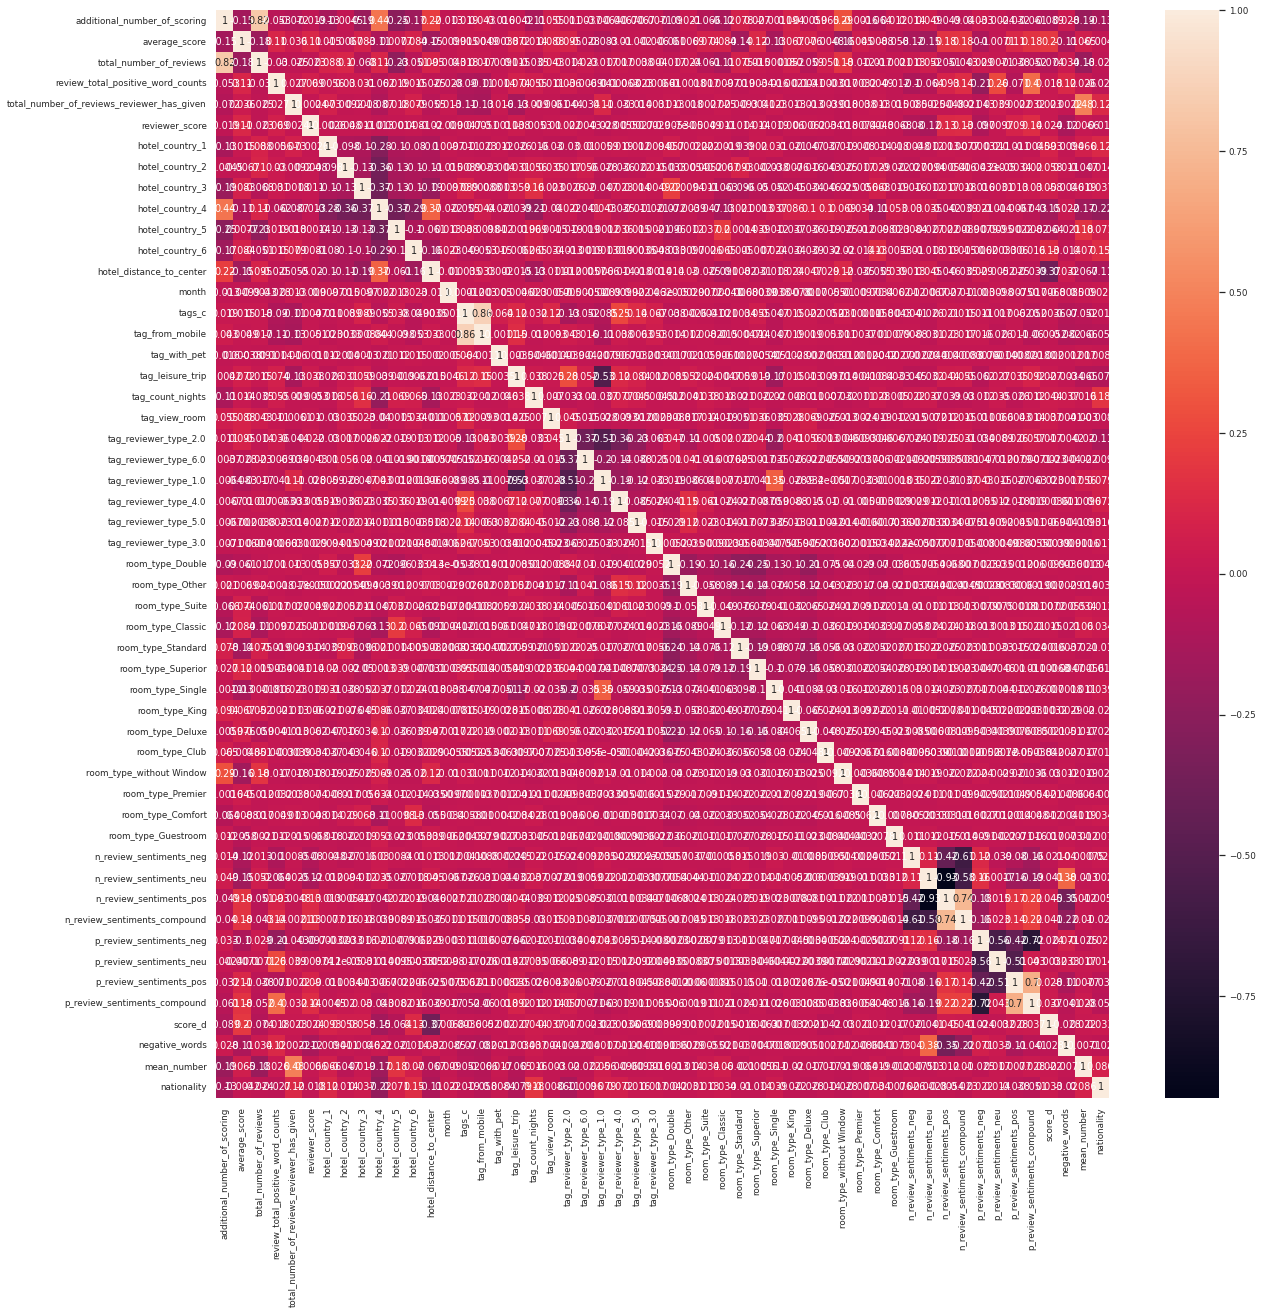

In [81]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(df_train_w.drop(['sample'], axis=1).corr(), annot=True)

### ОЦЕНКА ЗНАЧИМОСТИ ПРИЗНАКОВ

Проведем оценку значимости признаков. Воспользуемся для оценки дисперсионным анализом ANOVA. Теперь делить признаки на группы не корректно, нам нужно получить абсолютно худшие во всей совокупности:

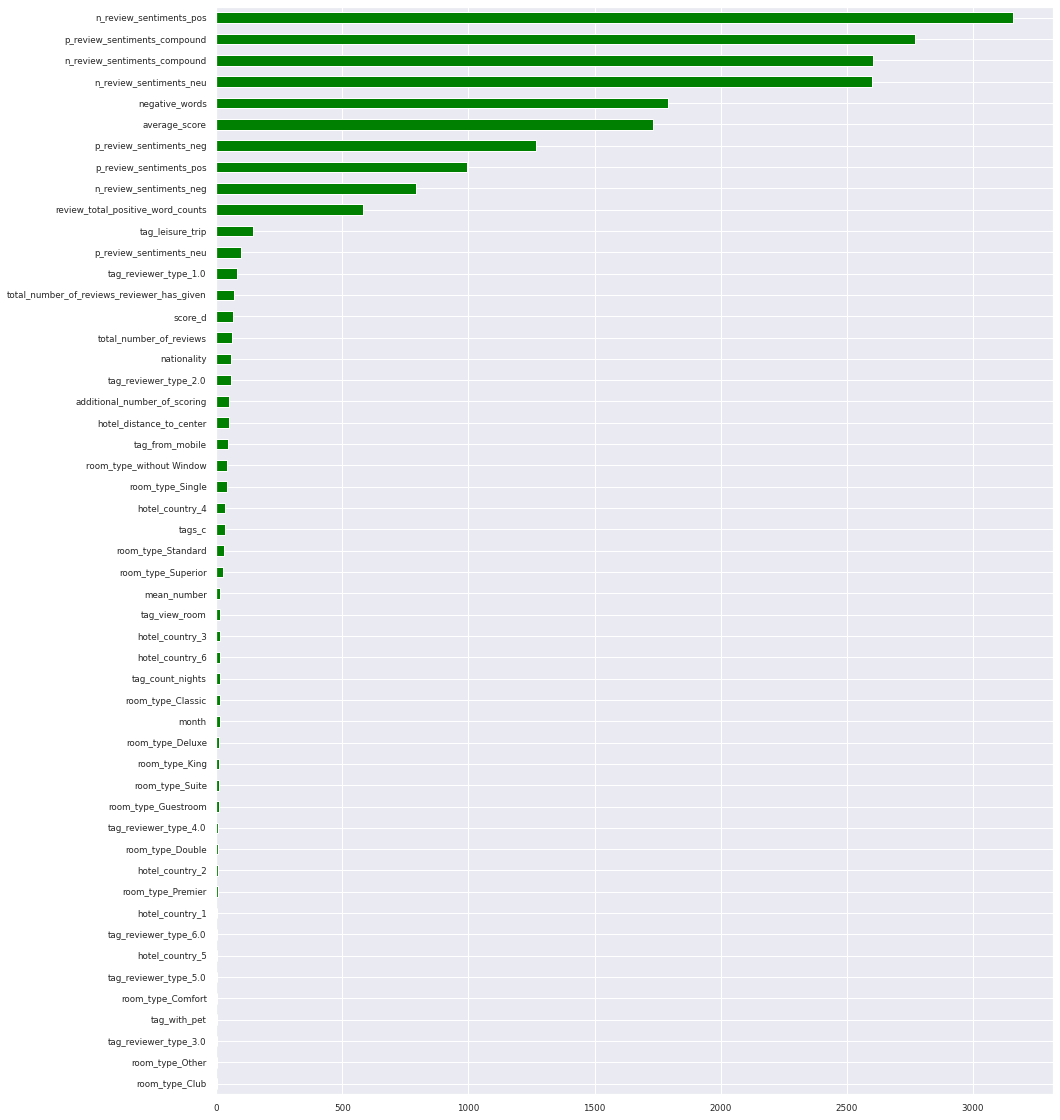

In [83]:
y = df_train_w.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = df_train_w.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

Удалим признаки, не демонстрирующие никакой корреляции с целевым. Это признаки некоторых типов номеров и типов путешественника, а также признак путешественников с животными.

In [85]:
drop_columns = ['room_type_Other', 'room_type_Club', 'room_type_Comfort', 
                'room_type_Double', 'room_type_Premier', 'tag_with_pet',
                'tag_reviewer_type_3.0', 'tag_reviewer_type_4.0', 
                'tag_reviewer_type_5.0', 'tag_reviewer_type_6.0']

In [86]:
# удалим незначимые числовые данные:
print(f'Удалим еще {len(drop_columns)} столбцов с числовыми данными')
df_train_w.drop(drop_columns, axis = 1, inplace=True)

Удалим еще 10 столбцов с числовыми данными


### Нормализация не влияет на конечный результат. Поэтому в данном анализе она была проведена и за ненадобностью исключена

### Проведем обучение модели

In [87]:
# инструменты для построения модели:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

RANDOM_SEED = 42

In [91]:
train_data = df_train_w.query('sample == 1').drop(['sample'], axis=1)
test_data = df_train_w.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data.reviewer_score.values

In [92]:
# воспользуемся специальной функцие train_test_split для разделения тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [93]:
# проверяем размеры:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 42), (386803, 42), (386803, 41), (309442, 41), (77361, 41))

In [94]:
# НАСТРОЙКИ 
model = RandomForestRegressor(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1, 
    random_state=RANDOM_SEED)


In [95]:
%%time

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s


CPU times: user 10min 36s, sys: 1.55 s, total: 10min 37s
Wall time: 2min 42s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


In [96]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), 
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную 
# процентную ошибку предсказанных значений от фактических:

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.11


### Определеим влияние оставленных признаков

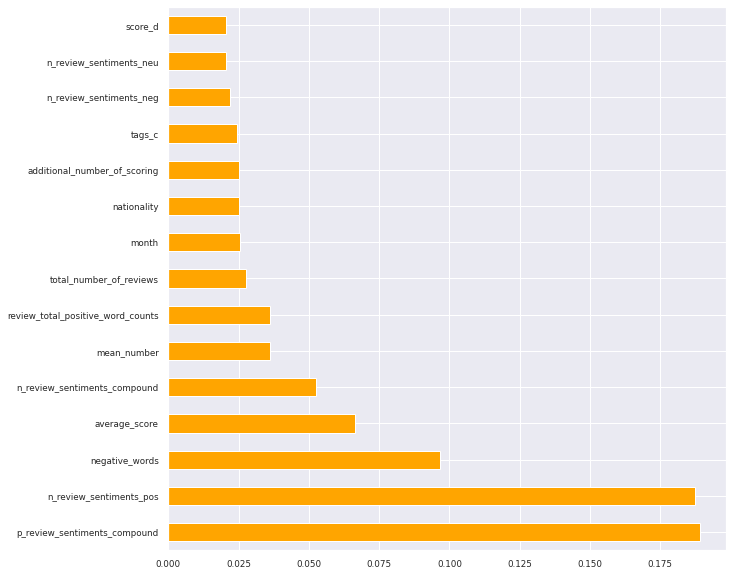

In [97]:
# вывод признаков
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='orange');

In [98]:
data = df_train_w.query('sample == 0').drop(['sample'], axis=1)
test_data = data.drop(['reviewer_score'], axis=1)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                128935 non-null  int64  
 1   average_score                               128935 non-null  float64
 2   total_number_of_reviews                     128935 non-null  int64  
 3   review_total_positive_word_counts           128935 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  128935 non-null  int64  
 5   hotel_country_1                             128935 non-null  int64  
 6   hotel_country_2                             128935 non-null  int64  
 7   hotel_country_3                             128935 non-null  int64  
 8   hotel_country_4                             128935 non-null  int64  
 9   hotel_country_5                             128935 non-null  int64  
 

In [99]:

predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

#  сохраняем результат:
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.4s finished


,reviewer_score,id
0,8.674,488440
1,7.407,274649
2,8.386,374688
3,9.802,404352
4,9.574,451596
5,8.840,302161
6,7.634,317079
7,7.325,13963
8,8.349,159785
9,7.593,195089
